# average normal featurmap vs anos

In [1]:
import torch
import torch.nn.functional as F
from models import Create_nets
from datasets import get_dataloader
#from options import TrainOptions
from torchvision import models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


import torch
import torchmetrics
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import cv2
from utils.results import *
from matplotlib.cm import viridis
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#args = TrainOptions().parse() # surpass kernelerror with this:

# helper functions
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
    return z

def load_image(filename,crop_size=256,aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225 ])    
            img=img.to(torch.float32)
        return img
    
def plot_images(images):
    num_images = images.shape[0]
    num_rows = int(num_images ** 0.5)
    num_cols = num_images // num_rows
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='viridis')
        ax.axis('off')
    plt.subplots_adjust(wspace=0.01, hspace=0.05)  # Adjust the spacing between subplots
    plt.show()
    
def plot_multi_map(resdict,title,index):
    
    extramaps=7
    squared_difftotal=(resdict['featuremaps'][index][:,:,:,:].squeeze().cpu().numpy()-resdict['recons'][index][:,:,:,:].squeeze().cpu().numpy())**2
    squared_diffhigh=(resdict['featuremaps'][index][:,:64,:,:].squeeze().cpu().numpy()-resdict['recons'][index][:,:64,:,:].squeeze().cpu().numpy())**2
    squared_diffmid=(resdict['featuremaps'][index][:,64:128,:,:].squeeze().cpu().numpy()-resdict['recons'][index][:,64:128,:,:].squeeze().cpu().numpy())**2
    squared_difflow=(resdict['featuremaps'][index][:,128:,:,:].squeeze().cpu().numpy()-resdict['recons'][index][:,128:,:,:].squeeze().cpu().numpy())**2

    squared_diffs = [squared_difftotal, squared_diffhigh, squared_diffmid, squared_difflow]
    titles = ['Total Squared Difference', 'High Squared Difference', 'Mid Squared Difference', 'Low Squared Difference']
    fig, axes = plt.subplots(1, len(squared_diffs) + extramaps, figsize=(20, 4))
    
    axes[0].imshow(Image.open(resdict['paths'][index]))
    axes[0].set_title(f'{title}'),axes[0].axis('off')
    
    axes[1].imshow( resdict['l2_out_recon'][index])
    axes[1].set_title(f'l2_out_recon (paper)'),axes[1].axis('off')
    
    axes[2].imshow( resdict['stds'][index])
    axes[2].set_title(f'stds (paper)'),axes[1].axis('off')
    
    axes[3].imshow(resdict['distances'][index])
    axes[3].set_title(f'distances (paper)'),axes[1].axis('off')
    
    axes[4].imshow( resdict['scoringmaps'][index])
    axes[4].set_title(f'scoring (paper)'),axes[1].axis('off')
    
    axes[5].imshow( sum(squared_difftotal)/resdict['stds'][index])
    axes[5].set_title(f'Total Squared Difference/ stds'),axes[1].axis('off')
    
    axes[6].imshow( resdict['scoringmapsown'][index])
    axes[6].set_title(f'ownscoringmap'),axes[1].axis('off')


    for i, squared_diff in enumerate(squared_diffs):
        axes[i+extramaps].imshow(sum(squared_diff))
        axes[i+extramaps].set_title(titles[i])
        axes[i+extramaps].axis('off')
    plt.tight_layout(),plt.show()

def sprite_image(imlist,title='Anomalies Test'):
    num_images = len(imlist)
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    # Find the maximum height and width among all images
    max_height = max(image.shape[0] for image in imlist)
    max_width = max(image.shape[1] for image in imlist)
    sprite_image = np.zeros((max_height * rows, max_width * cols, 3), dtype=np.uint8)
    for i, image in enumerate(imlist):
        row_idx = i // cols
        col_idx = i % cols
        colored_image = viridis(image / np.max(image))  # Normalize grayscale values and apply colormap
        colored_image = (colored_image[:, :, :3] * 255).astype(np.uint8)  # Multiply by 255 to convert to uint8
        
        sprite_image[row_idx * max_height:(row_idx + 1) * max_height,
                    col_idx * max_width:(col_idx + 1) * max_width, :] = colored_image

    plt.figure(figsize=(10, 10))
    plt.imshow(sprite_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def move_to_cpu(resdict):
    for k,v in resdict.items():
        if isinstance(v,torch.Tensor):
            resdict[k]=v.detach.cpu().numpy()
        if isinstance(v,np.ndarray):
            resdict[k]=[i.cpu().numpy() for i in v]
    return resdict

def plot_images_grid(imlist, title='Anomalies Test', figsize=(5, 5)):
    num_images = len(imlist)
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    fig, axes = plt.subplots(rows, cols, figsize=figsize, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
    fig.suptitle(title, y=0.93)  # Adjust the value of 'y' to move the title closer to the subplots

    for i, image in enumerate(imlist):
        row_idx = i // cols
        col_idx = i % cols

        ax = axes[row_idx, col_idx]
        ax.imshow(image, cmap='viridis')
        ax.axis('off')

    # Hide empty subplots
    for j in range(i + 1, rows * cols):
        row_idx = j // cols
        col_idx = j % cols
        axes[row_idx, col_idx].axis('off')

    plt.show() 

anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'scratch','squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination', 'thread'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'combined','contamination', 'crack', 'faulty_imprint', 'pill_type','scratch'],
    'screw': ['manipulated_front', 'scratch_head', 'scratch_neck','thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil','rough'],
    'toothbrush': ['defective'],
    'transistor': ['bent_lead', 'cut_lead', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'combined','fabric_border', 'fabric_interior','split_teeth','rough', 'squeezed_teeth']}

def inference(path_list,CHECKPOINT_PATH,args):

    checkpoint = torch.load(CHECKPOINT_PATH)
    img_list=[load_image(path,aligned=False) for path in path_list]

    ## doesnt work in a funcioton beacaus of hooks ->> 
    featuremaps,recons,stds,distances,scoringmaps,scoringmapsown, l2_out_recon=[],[],[],[],[],[],[]

    ## Load Pretrained  Trafo model
    transformer = Create_nets(args).to(device)
    transformer.load_state_dict(checkpoint['transformer'])
    transformer.eval()
    
    # Backbone hooks
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)


    with torch.no_grad():
        for img in img_list:
            img=img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)  
            outputs = embedding_concat(embedding_concat(outputs[0],outputs[1]),outputs[2])
            recon, std = transformer(outputs)
            
            #learn only form recon and stds
            featuremaps.append(outputs)
            recons.append(recon)
            stds.append(std.squeeze().cpu().numpy())
            l2_out_recon_i=torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).squeeze().cpu().numpy()
            
            l2_out_recon.append(l2_out_recon_i)
            
            dist = torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True).div(std.abs())
            distances.append(dist.squeeze().cpu().numpy())
            
            # Scroign from paper
            patch_normed_score = []
            for j in range(4):
                patch_size = pow(4, j)
                patch_score = F.conv2d(input=dist, 
                    weight=(torch.ones(1,1,patch_size,patch_size) / (patch_size*patch_size)).to(device), 
                    bias=None, stride=patch_size, padding=0, dilation=1)
                patch_score = F.avg_pool2d(dist,patch_size,patch_size)
                patch_score = F.interpolate(patch_score, (64,64), mode='bilinear')
                patch_normed_score.append(patch_score)    
            score = torch.zeros(1,1,64,64).to(device)
            for j in range(4):
                score = embedding_concat(score, patch_normed_score[j])
            score = F.conv2d(input=score, weight=torch.tensor([[[[0.0]],[[0.25]],[[0.25]],[[0.25]],[[0.25]]]]).to(device), bias=None, stride=1, padding=0, dilation=1)
            score = F.interpolate(score, (64,64), mode='bilinear')
            scoringmaps.append(score.squeeze().cpu().numpy())
            
            #own scoring , just use to squerad norm
            dist_own = (torch.norm(recon - outputs, p = 2, dim = 1, keepdim = True)**2).div(std.abs())
            patch_normed_score = []
            for j in range(4):
                patch_size = pow(4, j)
                patch_score = F.conv2d(input=dist_own, 
                    weight=(torch.ones(1,1,patch_size,patch_size) / (patch_size*patch_size)).to(device), 
                    bias=None, stride=patch_size, padding=0, dilation=1)
                patch_score = F.avg_pool2d(dist_own,patch_size,patch_size)
                patch_score = F.interpolate(patch_score, (64,64), mode='bilinear')
                patch_normed_score.append(patch_score)    
            score = torch.zeros(1,1,64,64).to(device)
            for j in range(4):
                score = embedding_concat(score, patch_normed_score[j])
            score = F.conv2d(input=score, weight=torch.tensor([[[[0.0]],[[0.25]],[[0.25]],[[0.25]],[[0.25]]]]).to(device), bias=None, stride=1, padding=0, dilation=1)
            score = F.interpolate(score, (64,64), mode='bilinear')
            scoringmapsown.append(score.squeeze().cpu().numpy())
            
    resdict={'paths':path_list,'featuremaps':featuremaps,'recons':recons,'stds':stds, 'l2_out_recon':l2_out_recon , 'distances':distances,'scoringmaps':scoringmaps,'scoringmapsown':scoringmapsown}
    return resdict

In [2]:
category= "grid"

class TrainOptions:
    def __init__(self):
        self.exp_name = "Exp0-r18"
        self.epoch_start = 0
        self.epoch_num = 150
        self.factor = 1
        self.seed = 233
        self.num_row = 4
        self.activation = 'gelu'
        self.unalign_test = False
        self.data_root = '/home/bule/projects/datasets/mvtec_anomaly_detection/'
        self.dataset_name = category
        self.batch_size = 2
        self.lr = 1e-4
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.image_result_dir = 'result_images'
        self.model_result_dir = 'saved_models'
        self.validation_image_dir = 'validation_images'

args = TrainOptions()
torch.manual_seed(args.seed)

In [3]:


SAVE_PATH='/home/bule/projects/UTRAD/results/mvtec/clean/'
CHECKPOINT_PATH = f'{SAVE_PATH}/Exp0-r18-{category}/saved_models/checkpoint.pth'
SAVE_DICTS_PATH='/home/bule/projects/UTRAD/results/mvtec/featuremap_similarities/'

CHECKPOINT_PATH=f'/home/bule/projects/UTRAD/results/mvtec/contamination_0/Exp_04_06_24_run_3-{category}/saved_models/checkpoint.pth'


if os.path.exists(f'{SAVE_DICTS_PATH}/{category}_good.npy'):
    
    #resdict_good=load_data_to_cpu(f'{SAVE_DICTS_PATH}/{category}_good.npy')
        

    resdict_good=np.load(f'{SAVE_DICTS_PATH}/{category}_good.npy',allow_pickle=True).item()
    resdict_good=move_to_cpu(resdict_good)
    print('already exists , loadded')
else:
    goodims=[ os.path.join(args.data_root,f'{category}/train/good',img ) for img in os.listdir(os.path.join(args.data_root,f'{category}/train/good'))]
    resdict_good=inference(goodims,CHECKPOINT_PATH,args)
    
    
    resdict_good=move_to_cpu(resdict_good)
    
    np.save(f'{SAVE_DICTS_PATH}/{category}_good.npy',resdict_good)

# uncommetn if there is free space on the gpu
# if os.path.exists(f'{SAVE_DICTS_PATH}/{category}_anomalies.npy'):
#     resdict_anos=np.load(f'{SAVE_DICTS_PATH}/{category}_anomalies.npy',allow_pickle=True).item()
#     print('already exists , loadded')
# else:
#     file_paths = []
#     directory = os.path.join(args.data_root, f'{category}/test')
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             file_paths.append(os.path.join(root, file))
#     anopaths = [file for file in file_paths if file.endswith('.png') and 'good' not in file]
#     resdict_anos=inference(anopaths,CHECKPOINT_PATH,args)
#     np.save(f'{SAVE_DICTS_PATH}/{category}_anomalies.npy',resdict_anos)



/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_We

In [ ]:

# import torch
# import torch.nn as nn
# import matplotlib.pyplot as plt
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# testing = resdict_good['featuremaps'][0].to(device)  # Ensure testing is on the correct device

# # Define the convolutional layer
# input_dim = 448
# d_model = 512
# conv_layer = nn.Conv2d(input_dim, d_model, kernel_size=1, bias=False).to(device)  # Move to device

# # Function to plot feature maps
# def plot_feature_maps(tensor, title, num_maps=16):
#     num_maps = min(num_maps, tensor.shape[1])  # Limit the number of maps to plot
#     rows = (num_maps + 3) // 4
#     fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(12, rows * 3))
#     for i, ax in enumerate(axes.flat):
#         if i < num_maps:
#             ax.imshow(tensor[0, i].detach().cpu().numpy(), cmap='viridis')
#             ax.axis('off')
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()

# # Plot all input feature maps (up to 448 for visualization purposes)
# plot_feature_maps(testing, title='Input Feature Maps', num_maps=448)

# # Apply the convolutional layer to the input tensor
# output = conv_layer(testing)

# # Plot all output feature maps (up to 512 for visualization purposes)
# plot_feature_maps(output, title='Output Feature Maps', num_maps=512)


## median

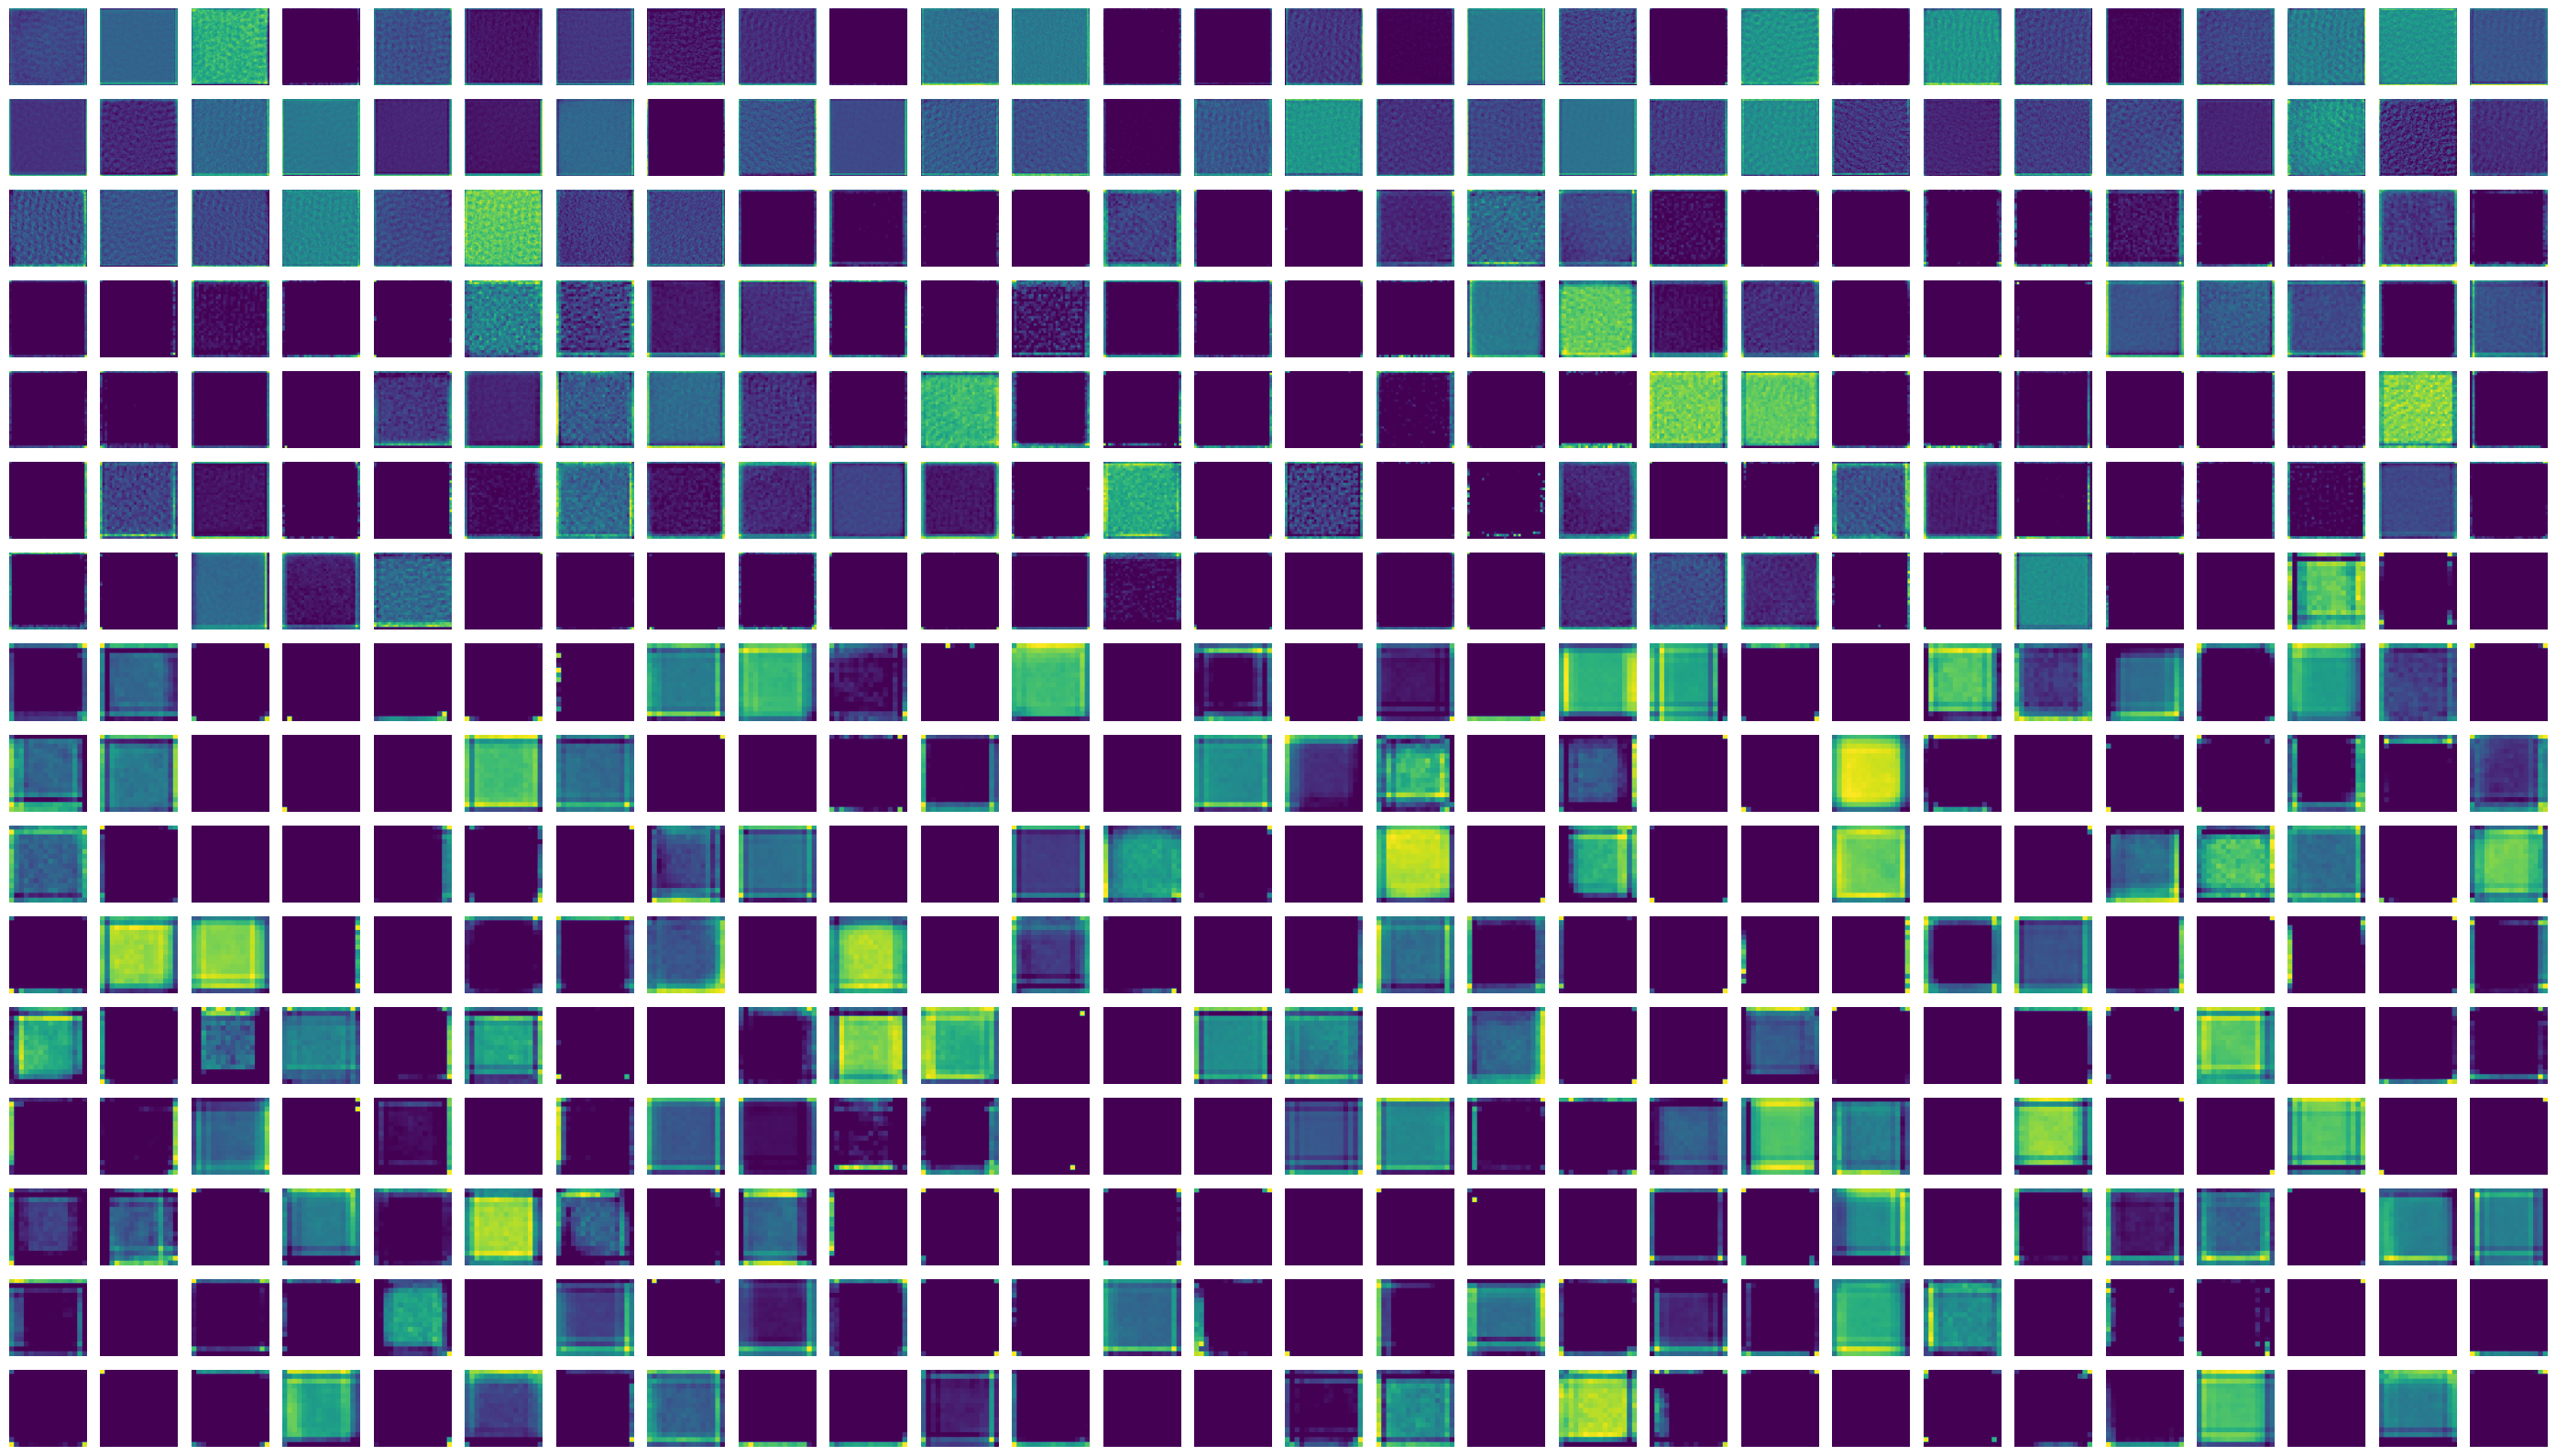

In [4]:
concatenated_tensor=torch.cat(resdict_good['featuremaps'])
mean_tensor = torch.median(concatenated_tensor, dim=0).values #torch.mean(concatenated_tensor, dim=0)
mean_tensor_cpu = mean_tensor.cpu().numpy()
num_feature_maps = mean_tensor_cpu.shape[0]
fig, axes = plt.subplots(nrows=16, ncols=28, figsize=(28, 16))
for i in range(num_feature_maps):
    row = i // 28
    col = i % 28
    ax = axes[row, col]
    ax.imshow(mean_tensor_cpu[i], cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()

## sanity check ssim

/home/bule/anaconda3/envs/ultrad/lib/python3.9/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0,

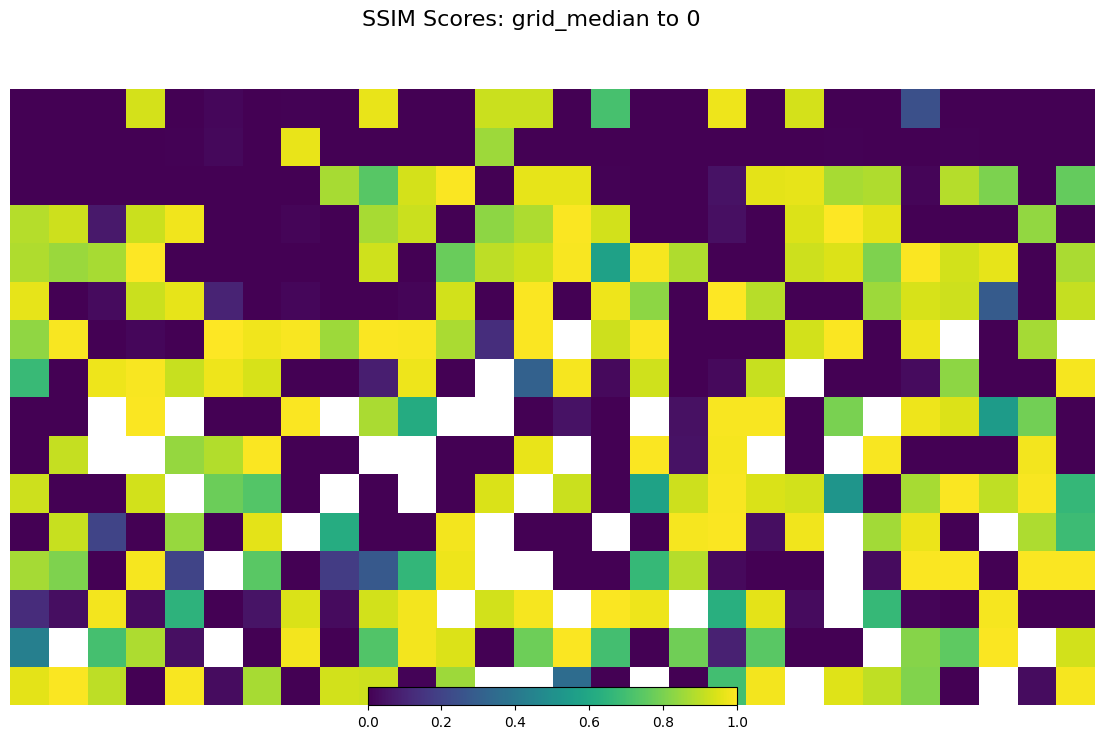

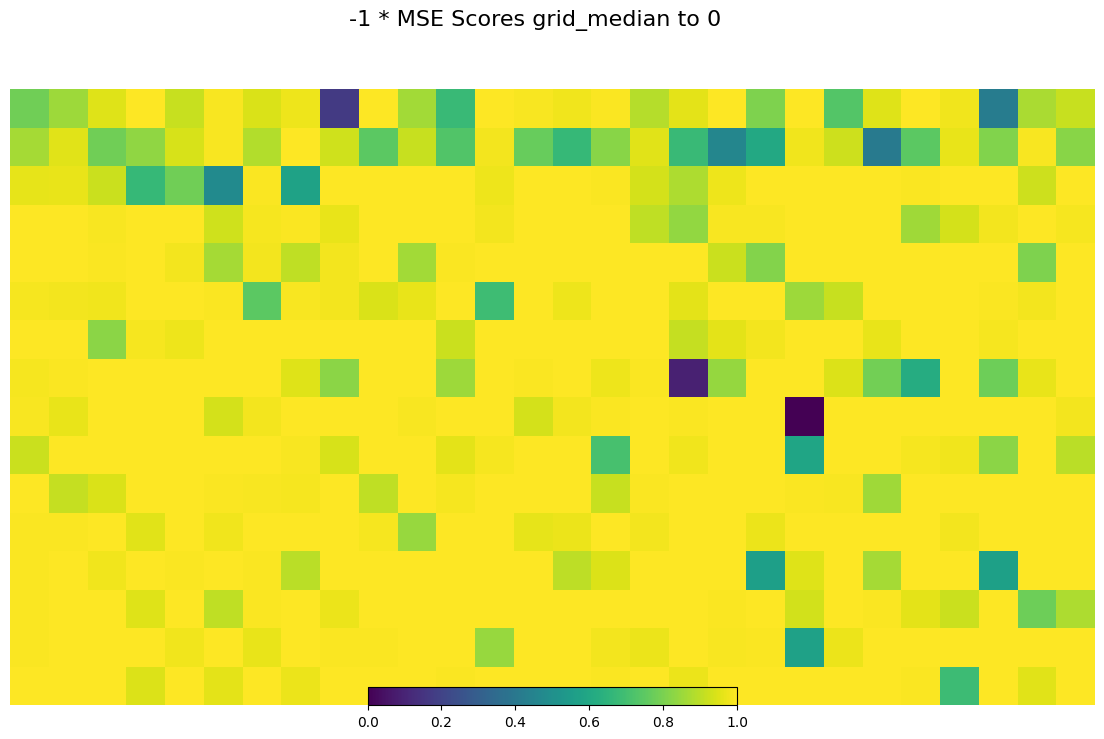

In [5]:
# SANITY CHECK, 1 means SIMILAR , -1 means not similar
check_tens=mean_tensor.cpu().numpy()
ssim_scores = []
for i in range(mean_tensor.shape[0]):
        ssim_index = ssim(check_tens[i], check_tens[i], data_range=check_tens[i].max() - check_tens[i].min())
        ssim_scores.append(ssim_index)
print(ssim_scores)

ssim_scores = []
mse_scores = []

for i in range(mean_tensor.shape[0]):
        ssim_index = ssim(check_tens[i], np.zeros_like(check_tens)[i], data_range=check_tens[i].max() - check_tens[i].min())
        ssim_scores.append(ssim_index)
        mse_index=np.mean((check_tens[i]-np.zeros_like(check_tens)[i])**2)
        mse_scores.append(mse_index)

print(ssim_scores)
print(mse_scores)


# zeroes=np.zeros_like(check_tens)
# fig, axes = plt.subplots(nrows=16, ncols=28, figsize=(28, 16))
# for i in range(num_feature_maps):
#     row = i // 28
#     col = i % 28
#     ax = axes[row, col]
#     ax.imshow(zeroes[i], cmap='viridis')
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

num_feature_maps = mean_tensor.shape[0]
fig, axes = plt.subplots(nrows=16, ncols=28, figsize=(14, 8), gridspec_kw={'wspace': 0, 'hspace': 0})

for i in range(num_feature_maps):
    row = i // 28
    col = i % 28
    ax = axes[row, col]
    cax = ax.imshow(np.full((64, 64), ssim_scores[i]), cmap='viridis', vmin=0, vmax=1)
    ax.axis('off')

# Add a color bar
cbar = fig.colorbar(cax, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04)
fig.suptitle(f'SSIM Scores: {category}_median to 0 ', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig, axes = plt.subplots(nrows=16, ncols=28, figsize=(14, 8), gridspec_kw={'wspace': 0, 'hspace': 0})

scaled_mse =(-1*np.array(mse_scores)).tolist()

scaled_mse = (scaled_mse - np.min(scaled_mse)) / (np.max(scaled_mse) - np.min(scaled_mse))


for i in range(num_feature_maps):
    row = i // 28
    col = i % 28
    ax = axes[row, col]
    cax = ax.imshow(np.full((64, 64), scaled_mse[i]), cmap='viridis', vmin=0, vmax=1)
    ax.axis('off')

# Add a color bar
cbar = fig.colorbar(cax, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04)
fig.suptitle(f'-1 * MSE Scores {category}_median to 0', fontsize=16)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### SSIM (MEDIAN(NORMALS) , ANO_j)

In [ ]:
all_anos=torch.cat(resdict_anos['featuremaps']).cpu().numpy()
sim_heatmaps=[]
zeroes=np.zeros_like(check_tens)

mean_tens=mean_tensor.cpu().numpy()

for ano_j in range(all_anos.shape[0]):
    ssim_scores = []
    for i in range(mean_tensor.shape[0]):
            ssim_index = ssim(mean_tens[i], all_anos[ano_j][i], data_range=all_anos[ano_j][i].max() - all_anos[ano_j][i].min())
            ssim_scores.append(ssim_index)
    sim_heatmaps.append(ssim_scores)

In [ ]:



import ipywidgets as widgets
ano_slider = widgets.IntSlider(value=0,min=0,max=all_anos.shape[0],step=1,description='ano_nr:')  

def ssim_heatmaps_test_per_ano(ano_j):
    fig, axes = plt.subplots(nrows=16, ncols=28, figsize=(14, 8), gridspec_kw={'wspace': 0, 'hspace': 0})

    for i in range(num_feature_maps):
        row = i // 28
        col = i % 28
        ax = axes[row, col]
        cax = ax.imshow(np.full((64, 64), sim_heatmaps[ano_j][i]), cmap='viridis', vmin=-1, vmax=1)
        ax.axis('off')

    # Add a color bar
    cbar = fig.colorbar(cax, ax=axes, orientation='horizontal', fraction=0.03, pad=0.04)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    

  
widgets.interact(ssim_heatmaps_test_per_ano, ano_j=ano_slider)